# Titanic challenge

**Goal**: Use machine learning to predict survival of Titanic passengers based on their age, sex, passenger class, and more.

Contents of this notebook:
- [Import libraries](#Import-libraries)
- [Exploratory data analysis](#Exploratory-data-analysis)
    - [Load data and look at structure](#Load-data-and-look-at-structure)
    - [Visualize relationships between variables](#Visualize-relationships-between-variables)
- [Data cleaning/preprocessing](#Data-cleaning/preprocessing)
    - [Convert categorical variables to dummy variable representation](#Convert-categorical-variables-to-dummy-variable-representation)
        - [Pclass](#Pclass)
        - [Sex](#Sex)
    - [Impute age](#Impute-age)
    - [Min-max scale continuous variables](#Min-max-scale-continuous-variables)
- [Create model](#Create-model)

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
%matplotlib inline

# Exploratory data analysis

## Load data and look at structure

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Initial thoughts:
- At first glance/intuition, important variables for predicting survival might be:
    * Sex ("Women and children first"?)
    * Age (see above)
    * Pclass (wealthier people may have been more likely to get on a life boat)
    * Fare (possibly another way to view wealth)
    * Parch: # of parents/children aboard (maybe parents of children were more likely to be saved)
    * SibSp: # of siblings/spouses aboard (large families more likely to survive (or less?)?)
- Probably not as important (but let's see):
    * Cabin
    * Embarked
    * Ticket
- There are a lot of missing entries for age. I'll probably want to impute some values, but not yet sure how (is age related to sex, class, etc.?).

## Visualize relationships between variables

First, a heatmap showing correlations between all continuous variables.

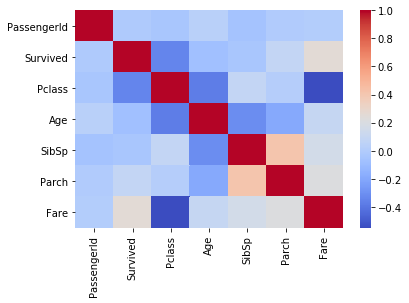

In [5]:
sns.heatmap(train_data.corr(), cmap='coolwarm')
plt.show()

Now, I'll look at the relationships between the variables that I predict will be most important for predicting survival: sex, passenger class, and age.

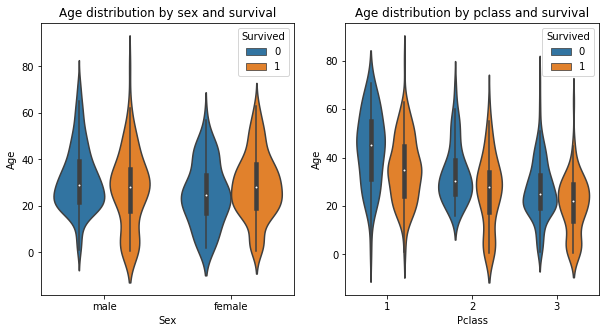

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Plot age distribution by sex and survival
sns.violinplot(x='Sex', y='Age', hue='Survived', data = train_data, ax=ax[0])
ax[0].set_title('Age distribution by sex and survival')

# Plot age distribution by class and survival
sns.violinplot(x='Pclass', y='Age', hue='Survived', data = train_data, ax=ax[1])
ax[1].set_title('Age distribution by pclass and survival')

plt.show()

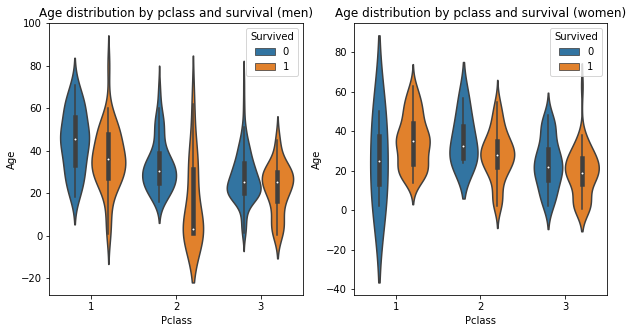

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Plot male data
men_data = train_data[train_data['Sex']=='male']
sns.violinplot(x='Pclass', y='Age', hue='Survived', data = men_data, ax=ax[0])
ax[0].set_title('Age distribution by pclass and survival (men)')

# Plot female data
women_data = train_data[train_data['Sex']=='female']
sns.violinplot(x='Pclass', y='Age', hue='Survived', data = women_data, ax=ax[1])
ax[1].set_title('Age distribution by pclass and survival (women)')

plt.show()

In [8]:
# Compute survival rate as a function of sex and pclass
pclass_sex = train_data.groupby(['Sex', 'Pclass'])['Survived'].mean()
print(pclass_sex)

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64


When grouped this way, both sex and pclass appear to be important when predicting survival. Let's look at this relationship with a visual.

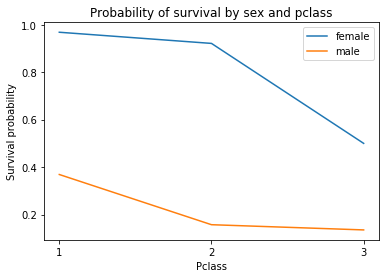

In [9]:
# x and y values to plot
pclass = [1,2,3] # x value
female_survival = pclass_sex.loc['female'].values # y value 1
male_survival = pclass_sex.loc['male'].values # y value 2

# Generate figure
plt.figure()
# Plot male and female survival rates by class
plt.plot(pclass, female_survival, label='female')
plt.plot(pclass, male_survival, label='male')
# Adjust appearance, add labels, etc.
plt.xticks(pclass) # it's distracting to have ticks where there are not classes (e.g., 1.5)
plt.xlabel('Pclass')
plt.ylabel('Survival probability')
plt.title('Probability of survival by sex and pclass')
plt.legend()
plt.show()

From this plot it is clear that:
- Women were much more likely to survive than men.
- For both men and women, first-class passengers were most likely to survive and third-class passengers were least likely to survive.
- The relationship between Pclass and survival probability is likely not linear, so classes should be treated as categorical rather than continuous.

I'll investigate other variables when I'm developing my model, but I think I have enough information now to perform necessary preprocessing.

# Data cleaning/preprocessing

## Convert categorical variables to dummy variable representation

### Pclass

In [10]:
# Convert class representation to one-hot
Pclass_onehot = to_categorical(train_data.Pclass-1, num_classes=3)
Pclass_1 = Pclass_onehot[:,0]
Pclass_2 = Pclass_onehot[:,1]
Pclass_3 = Pclass_onehot[:,2]

# Append new pclass variables to dataframe
train_data['Pclass_1'] = Pclass_1
train_data['Pclass_2'] = Pclass_2
train_data['Pclass_3'] = Pclass_3

Apply same changes to test dataset

In [11]:
# Convert class representation to one-hot
Pclass_onehot = to_categorical(test_data.Pclass-1, num_classes=3)
Pclass_1 = Pclass_onehot[:,0]
Pclass_2 = Pclass_onehot[:,1]
Pclass_3 = Pclass_onehot[:,2]

# Append new pclass variables to dataframe
test_data['Pclass_1'] = Pclass_1
test_data['Pclass_2'] = Pclass_2
test_data['Pclass_3'] = Pclass_3

### Sex

In [12]:
sex_dummyvar = (train_data['Sex']=='female').astype(int)
train_data['Female'] = sex_dummyvar

# Make sure things look okay; note new class columns and female column
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Female
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,1.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0,0.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0,0


Apply same changes to test dataset

In [13]:
sex_dummyvar = (test_data['Sex']=='female').astype(int)
test_data['Female'] = sex_dummyvar

## Impute age

What other variables are informative about passenger age? Let's look first at sex and passenger class.

In [14]:
# Compute median age as a function of sex and pclass
age_by_sex_class = train_data.groupby(['Sex', 'Pclass'])['Age'].median()
print(age_by_sex_class)

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64


There appears to be a trend of younger passengers in lower class. Let's visualize this with box plots.

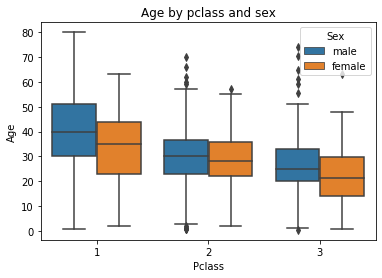

In [15]:
plt.figure()
sns.boxplot(data=train_data, x="Pclass", y="Age", hue="Sex")
plt.title('Age by pclass and sex')
plt.show()

The median age is lower for lower-class passengers. The median female age also appears to be less than the median male age. So both of these variables should be used for imputing age.

Are there any other important variables for imputing age?

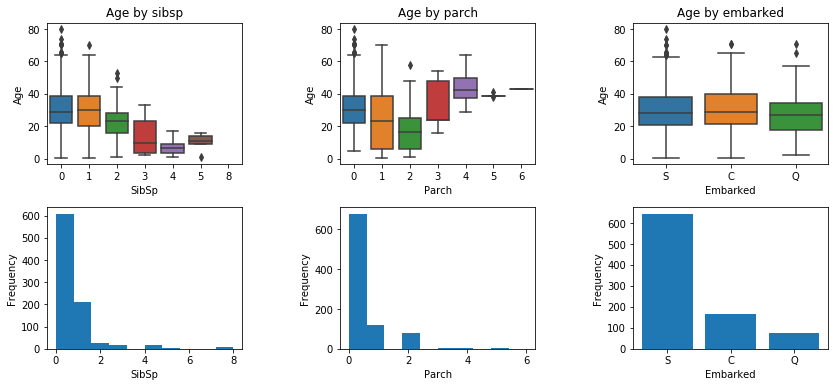

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,6))

ax = ax.ravel()

# Boxplots of age distribution, grouped by different variables
sns.boxplot(data=train_data, x="SibSp", y="Age", ax=ax[0])
ax[0].set_title('Age by sibsp')

sns.boxplot(data=train_data, x="Parch", y="Age", ax=ax[1])
ax[1].set_title('Age by parch')

sns.boxplot(data=train_data, x="Embarked", y="Age", ax=ax[2])
ax[2].set_title('Age by embarked')

# Histograms of distributions
ax[3].hist(data=train_data, x="SibSp")
ax[3].set_xlabel("SibSp")
ax[3].set_ylabel('Frequency')

ax[4].hist(data=train_data, x="Parch")
ax[4].set_xlabel("Parch")
ax[4].set_ylabel('Frequency')

ax[5].bar(train_data['Embarked'].value_counts().index, train_data['Embarked'].value_counts().values)
ax[5].set_xlabel('Embarked')
ax[5].set_ylabel('Frequency')

plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.3)

plt.show()

Generally, it looks like the passengers with more siblings aboard were younger. The data are too noisy to make any judgment about the relationship between number of parents/children aboard and age. There doesn't appear to be a relationship between port of embarkment and age.

However, from the histogram, it looks like the distribution of SibSp (and the other variables) is too uneven to use as a reliable predictor of age. So I'll just use sex and class to predict age.

In [17]:
# Use sex and pclass variables to predict age
X = train_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
Y = train_data['Age']

# Separate data by presence of nan for age
nanind = np.isnan(train_data['Age'])
X_nan = X.loc[nanind]
Y_nan = Y.loc[nanind]
X_notnan = X.loc[~nanind]
Y_notnan = Y.loc[~nanind]

# Fit regression model
linreg = LinearRegression().fit(X_notnan, Y_notnan)

Let's look at the coefficients of the regression to see if they make sense

In [18]:
# Print intercept and coefficients
print(f'Intercept: {linreg.intercept_}')
for var,val in dict(zip(X.columns.tolist(), linreg.coef_.tolist())).items():
    print(f'{var}: {val}')

Intercept: 32.875309974613735
Female: -4.585298136961219
Pclass_1: 7.453562829911552
Pclass_2: -1.0363385171852415
Pclass_3: -6.417224312726288


Looks reasonable. Women and lower-class passengers were generally younger, hence negative coefficients. Now I'll predict and impute the age of the missing data rows.


In [19]:
# Apply fitted model to predict age in samples with nan
age_pred = linreg.predict(X_nan)
train_data.loc[nanind,'Age'] = age_pred

# Verify that there are no nan in age column
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Pclass_1     891 non-null    float32
 13  Pclass_2     891 non-null    float32
 14  Pclass_3     891 non-null    float32
 15  Female       891 non-null    int32  
dtypes: float32(3), float64(2), int32(1), int64(5), object(5)
memory usage: 97.6+ KB


And now I'll apply the same imputation for the test data

In [20]:
# Use sex and pclass variables to predict age
X = test_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3']]

# Find indices that need to be replaced
test_nanind = np.isnan(test_data['Age'])
X_nan = X.loc[test_nanind]

# Apply fitted model to samples with nan age
age_pred = linreg.predict(X_nan)

test_data.loc[test_nanind,'Age'] = age_pred

Let's see if the regression actually works well. I'll predict the ages for all the test data and plot the predicted ages against the known ages.

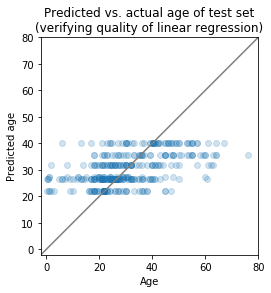

In [21]:
# Predict age of passengers in test dataset
age_pred = linreg.predict(X)

# Plot predicted age against actual age
plt.scatter(test_data['Age'], age_pred, alpha = 0.2)
# Plot identity line
plt.plot([-2, 80], [-2, 80], color = [0.5, 0.5, 0.5])

# Labels and appearance
plt.title('Predicted vs. actual age of test set\n(verifying quality of linear regression)')
plt.xlabel('Age')
plt.ylabel('Predicted age')
plt.axis('square')
plt.xlim((-2,80))
plt.ylim((-2,80))
plt.show()

Not spectacular, but better than nothing.

## Min-max scale continuous variables

In [22]:
# Fit scaler on training data, transform both training and testing data
scaler = MinMaxScaler()
train_data[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.fit_transform(train_data[['Age', 'Fare', 'SibSp', 'Parch']])
test_data[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.transform(test_data[['Age', 'Fare', 'SibSp', 'Parch']])

# Create model

Let's look at the correlation matrix again with the new variables (Pclass_1, Pclass_2, Pclass_3, Female)

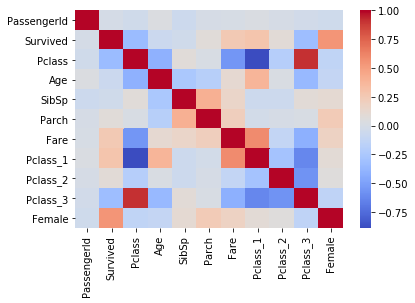

In [23]:
sns.heatmap(train_data.corr(), cmap='coolwarm')
plt.show()

Logistic regression on sex, age, pclass

In [24]:
# Perform logistic regression on dataframe with cross-validation, return array of CV scores
def logreg_cv(df):
    X = df.drop('Survived', axis=1)
    Y = df['Survived']
    return cross_val_score(LogisticRegression(), X, Y, cv = 200)

def nn_cv(df):
    X = df.drop('Survived', axis=1)
    Y = df['Survived']
    return cross_val_score(MLPClassifier(), X, Y, cv = 200)

def plot_cv_accuracy(keys, cv_results):
    fig, ax = plt.subplots(nrows=np.ceil(len(keys)/2).astype(int), ncols=2, figsize=(10,8))
    ax = ax.ravel()
    
    for ind,k in enumerate(keys):
        ax[ind].hist(cv_results[k], bins = np.arange(0.3, 1, 0.05))
        med = np.median(cv_results[k])
        ax[ind].axvline(med, color='k')
        ax[ind].set_xlabel('Cross-validation accuracy')
        ax[ind].set_title(f'{keys[ind]} (median CV accuracy: {med:.3f})')
        ax[ind].set_xlim((0.3, 1.05))
        
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [25]:
# Store cross-validation results in dictionary for plotting
logreg_cv_results = {}

# Classify based on just sex
logreg_cv_results['Sex'] = logreg_cv(train_data[['Female', 'Survived']])

# Classify based on just age
logreg_cv_results['Age'] = logreg_cv(train_data[['Age', 'Survived']])

# Classify based on just pclass
logreg_cv_results['Pclass'] = logreg_cv(train_data[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Survived']])

# Classify based on sex, age, and pclass
logreg_cv_results['SexAgePclass'] = logreg_cv(train_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'Survived']])

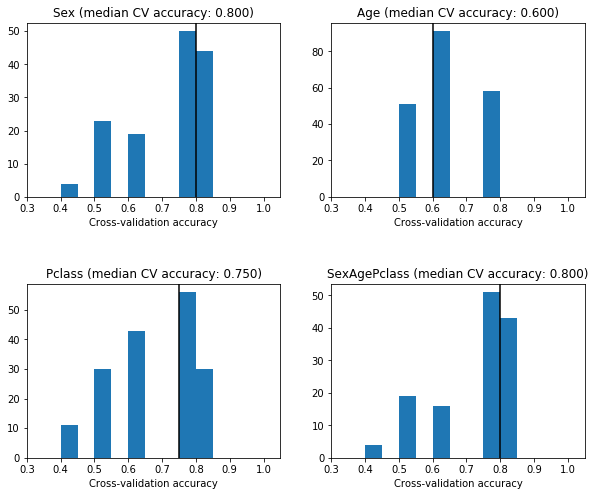

In [26]:
# Plot histogram of CV accuracy for each classifier
keys = ['Sex', 'Age', 'Pclass', 'SexAgePclass']
plot_cv_accuracy(keys, logreg_cv_results)

In [27]:
# Classify based on sex, pclass, age, sibsp
logreg_cv_results['SexPclassAgeSibsp'] = logreg_cv(train_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp', 'Survived']])

# Classify based on sex, pclass, age, sibsp, parch
logreg_cv_results['SexPclassAgeSibspParch'] = logreg_cv(train_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp', 'Parch', 'Survived']])

# Classify based on sex, pclass, age, sibsp, parch, fare
logreg_cv_results['SexPclassAgeSibspParchFare'] = logreg_cv(train_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']])

# Classify based on sex, age, and pclass
logreg_cv_results['SexAgePclass'] = logreg_cv(train_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'Survived']])

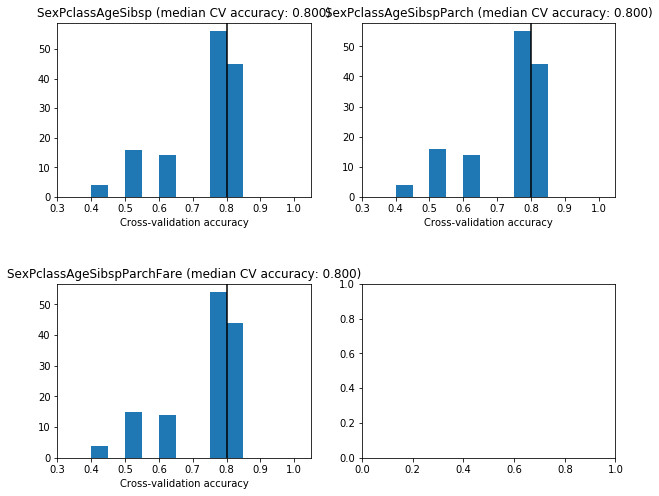

In [28]:
# Plot histogram of CV accuracy for each classifier
keys = ['SexPclassAgeSibsp', 'SexPclassAgeSibspParch', 'SexPclassAgeSibspParchFare']
plot_cv_accuracy(keys, logreg_cv_results)

Additional columns don't appear to help or hurt.

Time to make and save predictions!

In [29]:
# Fit logistic regression model
logreg = LogisticRegression().fit(train_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age']], train_data['Survived'])

# Make predictions on test data
Y_predictions = logreg.predict(test_data[['Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age']])

# Store predictions in dataframe
predictions = pd.DataFrame({'PassengerId': test_data['PassengerId'],
                            'Survived': Y_predictions
                           })

# Make sure everything looks okay
predictions.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [30]:
# Save predictions in csv
predictions.to_csv('predictions.csv', index = False)

# Open file to make sure it looks right
pd.read_csv('predictions.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


And so concludes my first Kaggle competition!